In [21]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_missing_data(df):
    missing_data = (df.isnull().sum() / df.shape[0]) * 100
    return dict(missing_data)

In [3]:
def fill_missed_values(df):
    missing_data = get_missing_data(df)
    for miss in missing_data:
        if missing_data[miss] > 0:
            try:
                df[miss] = df[miss].fillna(df[miss].mean())
            except:
                df[miss] = df[miss].fillna('missed')
    return df

In [4]:
def drop_rain_missed(df):
    idx = df[
        (df['RainToday'] == 'missed') |
        (df['RainTomorrow'] == 'missed')
    ].index
    return df.drop(idx)

In [5]:
def encoding_data(df):
    for column in df.columns:
        if type(df[column][2] == str):
            df[column] = le.fit_transform(df[column])
    return df

In [23]:
def show_cv_metrics(str, cv_result):
    print(f'{str}: {cv_result[str].mean()} +/- {cv_result[str].std()}')

In [6]:
train_ds = pd.read_csv('input/train.csv')
test_ds = pd.read_csv('input/test.csv')

In [7]:
train_ds.set_index('Id', inplace=True)
test_ds.set_index('Id', inplace=True)

In [8]:
train_ds = fill_missed_values(train_ds)
test_ds = fill_missed_values(test_ds)

In [9]:
data = pd.concat([train_ds, test_ds])
data.shape[0]

142193

In [10]:
data.drop(['Date', 'Location'], axis=1, inplace=True)
data.head(3)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Id,,,,,,,,,,,,,,,,,,,,,
2,7.4,25.1,0.0,5.464482,7.621446,WNW,44.0,NNW,WSW,4.0,...,44.0,25.0,1010.6,1007.8,4.425827,4.501143,17.2,24.3,No,No
3,12.9,25.7,0.0,5.464482,7.621446,WSW,46.0,W,WSW,19.0,...,38.0,30.0,1007.6,1008.7,4.425827,2.000000,21.0,23.2,No,No
4,9.2,28.0,0.0,5.464482,7.621446,NE,24.0,SE,E,11.0,...,45.0,16.0,1017.6,1012.8,4.425827,4.501143,18.1,26.5,No,No


In [11]:
print(get_missing_data(data))

{'MinTemp': 0.0, 'MaxTemp': 0.0, 'Rainfall': 0.0, 'Evaporation': 0.0, 'Sunshine': 0.0, 'WindGustDir': 0.0, 'WindGustSpeed': 0.0, 'WindDir9am': 0.0, 'WindDir3pm': 0.0, 'WindSpeed9am': 0.0, 'WindSpeed3pm': 0.0, 'Humidity9am': 0.0, 'Humidity3pm': 0.0, 'Pressure9am': 0.0, 'Pressure3pm': 0.0, 'Cloud9am': 0.0, 'Cloud3pm': 0.0, 'Temp9am': 0.0, 'Temp3pm': 0.0, 'RainToday': 0.0, 'RainTomorrow': 0.0}


In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [13]:
data_le = data
data_le.shape[0]

142193

In [14]:
data_le = drop_rain_missed(data_le)
data_le.shape[0]

140787

In [15]:
data_le = encoding_data(data_le)

In [16]:
X = data_le.drop('RainTomorrow', axis=1)
y = data_le['RainTomorrow']

In [17]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

folds = 3

kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1234)

model = xgb.XGBClassifier(objective='binary:logistic')

In [18]:
from sklearn.preprocessing import MinMaxScaler

np.random.seed(1234)

scaler = MinMaxScaler()

X[X.columns] = scaler.fit_transform(X[X.columns])

In [22]:
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

s = ['precision', 'recall', 'f1_macro', 'accuracy', 'roc_auc']

cv_result = cross_validate(model, X, y, cv=kfold, scoring=s, verbose=0)
cv_result

[17:27:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:28:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:28:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'fit_time': array([4.03759456, 4.03543067, 3.88527274]),
 'score_time': array([0.13840652, 0.11660051, 0.12257051]),
 'test_precision': array([0.7389501 , 0.74589951, 0.74060101]),
 'test_recall': array([0.54817308, 0.55096154, 0.54735122]),
 'test_f1_macro': array([0.77039724, 0.77319515, 0.77051311]),
 'test_accuracy': array([0.85695412, 0.85889322, 0.85718852]),
 'test_roc_auc': array([0.89012387, 0.88745788, 0.8855793 ])}

In [24]:
show_cv_metrics('test_precision', cv_result)
show_cv_metrics('test_recall', cv_result)
show_cv_metrics('test_f1_macro', cv_result)
show_cv_metrics('test_accuracy', cv_result)
show_cv_metrics('test_roc_auc', cv_result)

test_precision: 0.7418168724168387 +/- 0.0029644899289956294
test_recall: 0.5488286105379414 +/- 0.0015450781847480895
test_f1_macro: 0.7713684988682478 +/- 0.0012925040637775443
test_accuracy: 0.8576786208953951 +/- 0.00086416693499859
test_roc_auc: 0.8877203527474312 +/- 0.0018645716429750681


In [25]:
cv_result_df = pd.DataFrame(cv_result)
cv_result_df = cv_result_df.iloc[:,2:]
cv_result_df

,test_precision,test_recall,test_f1_macro,test_accuracy,test_roc_auc
0,0.738950,0.548173,0.770397,0.856954,0.890124
1,0.745900,0.550962,0.773195,0.858893,0.887458
2,0.740601,0.547351,0.770513,0.857189,0.885579


<AxesSubplot:>

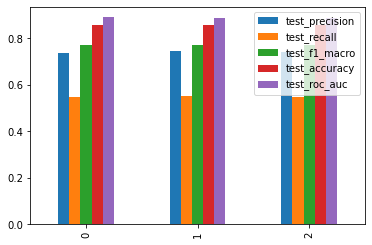

In [26]:
cv_result_df.plot(kind='bar')